# Custom Training Job with Tensorboard Monitoring

This notebook demonstrates how to submit a custom Vertex training job and monitor it using Vertex TensorBoard. 

## Scenario

The training scenario is fine-tuning BERT on the [GLUE COLA](https://nyu-mll.github.io/CoLA/) dataset. 

## Notes

- The training regimen utilizes  [TensorFlow NLP Modelling Toolkit](https://github.com/tensorflow/models/tree/master/official/nlp)
- Due to a complexity of the ML task, the custom training job is configured to use a multi-gpu training node

In [1]:
import os
import numpy as np
import time

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization

from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform.utils import TensorboardClientWithOverride
from google.cloud.aiplatform_v1beta1.types import Tensorboard

tf.get_logger().setLevel('ERROR')

## Evironment setup


In [2]:
PROJECT = 'jk-mlops-dev'
REGION = 'us-central1'
STAGING_BUCKET = 'gs://jk-vertex-workshop-bucket' 
VERTEX_SA = 'vertex-sa@jk-mlops-dev.iam.gserviceaccount.com'

## Configure data preprocessing

### Make BERT data preprocessing model

In [3]:
TFHUB_HANDLE_PREPROCESS = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

def make_bert_preprocess_model(sentence_features, seq_length=128):
    """Returns a model mapping string features to BERT inputs."""

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(TFHUB_HANDLE_PREPROCESS)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(segments)
    return tf.keras.Model(input_segments, model_inputs)

### Try BERT data preprocessing model

In [4]:
test_preprocess_model = make_bert_preprocess_model(['sentence1', 'sentence2'])
test_text = [np.array(['some random test sentence']), 
             np.array(['another random sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

INFO:absl:Using /tmp/tfhub_modules to cache modules.
Keys           :  ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6721 6251  102    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0], shape=(16,), dtype=int32)


### Visualize BERT data preprocessing model

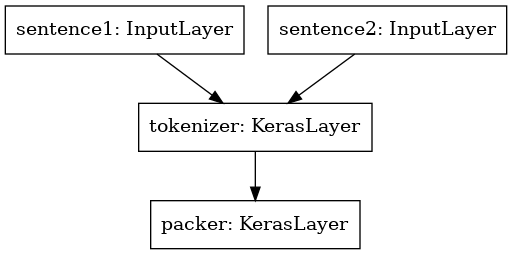

In [5]:
tf.keras.utils.plot_model(test_preprocess_model)

## Configure the text classification model

In [6]:
TFHUB_HANDLE_ENCODER = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'

def build_classifier_model(num_classes, dropout_ratio):
    """Creates a text classification model based on BERT encoder."""

    inputs = dict(
        input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
        input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
        input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
    )

    encoder = hub.KerasLayer(TFHUB_HANDLE_ENCODER, trainable=True, name='encoder')
    net = encoder(inputs)['pooled_output']
    net = tf.keras.layers.Dropout(rate=dropout_ratio)(net)
    net = tf.keras.layers.Dense(num_classes, activation=None, name='classifier')(net)
    return tf.keras.Model(inputs, net, name='prediction')

In [7]:
dropout_ratio = 0.1
classes = 2

classifier_model = build_classifier_model(classes, dropout_ratio)

### Test the model

In [8]:
bert_raw_result = classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.42943832 0.9724505 ]], shape=(1, 2), dtype=float32)


### Visualize the model

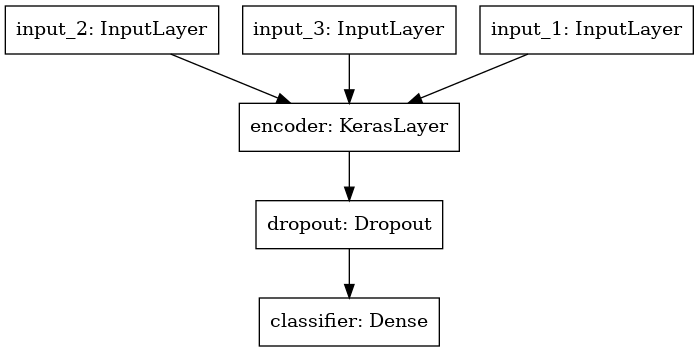

In [9]:
tf.keras.utils.plot_model(classifier_model)

## Configure `tf.data` pipelines

### Load the `glue/cola` dataset

We will use  [TensorFlow Datasets](https://www.tensorflow.org/datasets). Since the `glue/cola` dataset is rather small we will load to memory.

In [10]:
tfds_name = 'glue/cola' 

tfds_info = tfds.builder(tfds_name).info
num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples
sentence_features = list(tfds_info.features.keys())
available_splits = list(tfds_info.splits.keys())
labels_names = tfds_info.features['label'].names

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')
print(f'Labels names {labels_names}')

in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

INFO:absl:Load dataset info from /home/jupyter/tensorflow_datasets/glue/cola/1.0.0
Using glue/cola from TFDS
This dataset has 10657 examples
Number of classes: 2
Features ['sentence', 'label', 'idx']
Splits ['train', 'validation', 'test']
Labels names ['unacceptable', 'acceptable']
INFO:absl:Load dataset info from /home/jupyter/tensorflow_datasets/glue/cola/1.0.0
INFO:absl:Reusing dataset glue (/home/jupyter/tensorflow_datasets/glue/cola/1.0.0)
INFO:absl:Constructing tf.data.Dataset glue for split None, from /home/jupyter/tensorflow_datasets/glue/cola/1.0.0


### Show some examples

In [11]:
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds['train'])

for row in sample_dataset.take(2):
    print(row)

{'idx': <tf.Tensor: shape=(), dtype=int32, numpy=1680>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'sentence': <tf.Tensor: shape=(), dtype=string, numpy=b'It is this hat that it is certain that he was wearing.'>}
{'idx': <tf.Tensor: shape=(), dtype=int32, numpy=1456>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'sentence': <tf.Tensor: shape=(), dtype=string, numpy=b'Her efficient looking up of the answer pleased the boss.'>}


### Create data ingestion pipelines.

We will be training on a multi-gpu node using the `MirroredStrategy` distribution strategy. When using the `MirroredStrategy` each batch of the input is divided equally among the replicas. Typically, you would want to increase your batch size as you add more accelerators, so as to make effective use of the extra computing power.

In [12]:
strategy = tf.distribute.MirroredStrategy()

In [16]:
batch_size_per_replica = 16
global_batch_size = batch_size_per_replica * strategy.num_replicas_in_sync
features = ['sentence']


def get_data_pipeline(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):
    is_training = split.startswith('train')
    dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
    num_examples = info.splits[split].num_examples

    if is_training:
        dataset = dataset.shuffle(num_examples)
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset, num_examples


bert_preprocess_model = make_bert_preprocess_model(features)

train_dataset, train_data_size = get_data_pipeline(
      in_memory_ds, tfds_info, 'train', global_batch_size, bert_preprocess_model)

validation_dataset, validation_data_size = get_data_pipeline(
      in_memory_ds, tfds_info, 'validation', global_batch_size, bert_preprocess_model)


## Configure local training

### Compile the model

Fine-tuning follows the optimizer set-up from BERT pre-training (as in [Classify text with BERT](https://www.tensorflow.org/text/tutorials/classify_text_with_bert)): It uses the AdamW optimizer with a linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 3
init_lr = 2e-5
dropout_ratio = 0.1
num_classes = 2
steps_per_epoch = train_data_size // global_batch_size

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10
validation_steps = validation_data_size // global_batch_size

with strategy.scope():
    classifier_model = build_classifier_model(num_classes, dropout_ratio)
    optimizer = optimization.create_optimizer(
        init_lr=init_lr,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type='adamw')
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)
    
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics]) 

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


### Start a local training run

In [18]:
history = classifier_model.fit(
      x=train_dataset,
      validation_data=validation_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps)

Epoch 1/3
534/534 [==============================] - 266s 468ms/step - loss: 0.6197 - accuracy: 0.6631 - val_loss: 0.4313 - val_accuracy: 0.8298
Epoch 2/3
534/534 [==============================] - 248s 464ms/step - loss: 0.2934 - accuracy: 0.8826 - val_loss: 0.4768 - val_accuracy: 0.8308
Epoch 3/3
534/534 [==============================] - 248s 464ms/step - loss: 0.1798 - accuracy: 0.9399 - val_loss: 0.6637 - val_accuracy: 0.8260


## Run Vertex custom training job

### Create a training script

In [7]:
folder = 'trainer'
if tf.io.gfile.exists(folder):
    tf.io.gfile.rmtree(folder)
tf.io.gfile.mkdir(folder)
file_path = os.path.join(folder, 'train.py')

In [8]:
%%writefile {file_path}


# Copyright 2021 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#            http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and

import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa

from absl import app
from absl import flags
from absl import logging

from official.nlp import optimization

TFHUB_HANDLE_ENCODER = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
TFHUB_HANDLE_PREPROCESS = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
TFDS_NAME = 'glue/cola' 
NUM_CLASSES = 2
SENTENCE_FEATURE = 'sentence'

LOCAL_MODEL_DIR = '/tmp/saved_model'
LOCAL_TB_DIR = '/tmp/logs'
LOCAL_CHECKPOINT_DIR = '/tmp/checkpoints'

FLAGS = flags.FLAGS
flags.DEFINE_integer('epochs', 2, 'Nubmer of epochs')
flags.DEFINE_integer('per_replica_batch_size', 16, 'Per replica batch size')
flags.DEFINE_float('init_lr', 2e-5, 'Initial learning rate')
flags.DEFINE_float('dropout_ratio', 0.1, 'Dropout ratio')


def make_bert_preprocess_model(sentence_features, seq_length=128):
    """Returns a model mapping string features to BERT inputs."""

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(TFHUB_HANDLE_PREPROCESS)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
    segments = [tokenizer(s) for s in input_segments]

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                            arguments=dict(seq_length=seq_length),
                            name='packer')
    model_inputs = packer(segments)
    return tf.keras.Model(input_segments, model_inputs)


def build_classifier_model(num_classes, dropout_ratio):
    """Creates a text classification model based on BERT encoder."""

    inputs = dict(
        input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
        input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
        input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
    )

    encoder = hub.KerasLayer(TFHUB_HANDLE_ENCODER, trainable=True, name='encoder')
    net = encoder(inputs)['pooled_output']
    net = tf.keras.layers.Dropout(rate=dropout_ratio)(net)
    net = tf.keras.layers.Dense(num_classes, activation=None, name='classifier')(net)
    return tf.keras.Model(inputs, net, name='prediction')


def get_data_pipeline(in_memory_ds, info, split, 
                      batch_size,  bert_preprocess_model):
    """Creates a sentence preprocessing pipeline."""
    
    is_training = split.startswith('train')
    dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
    num_examples = info.splits[split].num_examples

    if is_training:
        dataset = dataset.shuffle(num_examples)
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset, num_examples


def set_job_dirs():
    """Sets job directories based on env variables set by Vertex AI."""
    
    model_dir = os.getenv('AIP_MODEL_DIR', LOCAL_MODEL_DIR)
    tb_dir = os.getenv('AIP_TENSORBOARD_LOG_DIR', LOCAL_TB_DIR)
    checkpoint_dir = os.getenv('AIP_CHECKPOINT_DIR', LOCAL_CHECKPOINT_DIR)
    
    return model_dir, tb_dir, checkpoint_dir
    

def main(argv):
    """Starts a training run."""
    
    del argv
    logging.info('Setting up training.')
    logging.info('   epochs: {}'.format(FLAGS.epochs))
    logging.info('   per_replica_batch_size: {}'.format(FLAGS.per_replica_batch_size))
    logging.info('   init_lr: {}'.format(FLAGS.init_lr))
    logging.info('   dropout_ratio: {}'.format(FLAGS.dropout_ratio))

    # Set distribution strategy
    strategy = tf.distribute.MirroredStrategy()
    
    global_batch_size = (strategy.num_replicas_in_sync *
                         FLAGS.per_replica_batch_size)
    
    # Configure input data pipelines
    tfds_info = tfds.builder(TFDS_NAME).info
    num_classes = tfds_info.features['label'].num_classes
    num_examples = tfds_info.splits.total_num_examples
    available_splits = list(tfds_info.splits.keys())
    labels_names = tfds_info.features['label'].names
    
    with tf.device('/job:localhost'):
        in_memory_ds = tfds.load(TFDS_NAME, batch_size=-1, shuffle_files=True)
        
    bert_preprocess_model = make_bert_preprocess_model([SENTENCE_FEATURE])

    train_dataset, train_data_size = get_data_pipeline(
        in_memory_ds, tfds_info, 'train', global_batch_size, bert_preprocess_model)

    validation_dataset, validation_data_size = get_data_pipeline(
        in_memory_ds, tfds_info, 'validation', global_batch_size, bert_preprocess_model)
    
    # Configure the model
    steps_per_epoch = train_data_size // global_batch_size
    num_train_steps = steps_per_epoch * FLAGS.epochs
    num_warmup_steps = num_train_steps // 10
    validation_steps = validation_data_size // global_batch_size
    
    with strategy.scope():
        classifier_model = build_classifier_model(NUM_CLASSES, FLAGS.dropout_ratio)
        optimizer = optimization.create_optimizer(
            init_lr=FLAGS.init_lr,
            num_train_steps=num_train_steps,
            num_warmup_steps=num_warmup_steps,
            optimizer_type='adamw')
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metrics = tf.keras.metrics.SparseCategoricalAccuracy(
            'accuracy', dtype=tf.float32)
    
    classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])
    
    model_dir, tb_dir, checkpoint_dir = set_job_dirs()

    # Configure Keras callbacks
    callbacks = [tf.keras.callbacks.experimental.BackupAndRestore(backup_dir=checkpoint_dir)]
    callbacks.append(tf.keras.callbacks.TensorBoard(
            log_dir=tb_dir, update_freq='batch'))
    
    logging.info('Starting training ...')
    classifier_model.fit(
        x=train_dataset,
        validation_data=validation_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=FLAGS.epochs,
        validation_steps=validation_steps,
        callbacks=callbacks)
        
    # Save trained model
    logging.info('Training completed. Saving the trained model to: {}'.format(model_dir))
    classifier_model.save(model_dir)  
    
if __name__ == '__main__':
    logging.set_verbosity(logging.INFO)
    app.run(main)

Writing trainer/train.py


### Intialize Vertex SDK

In [9]:
vertex_ai.init(
    project=PROJECT,
    location=REGION,
    staging_bucket=STAGING_BUCKET
)

### Create or set Tensorboard

In [10]:
tb_client = api_client = vertex_ai.initializer.global_config.create_client(
        client_class=TensorboardClientWithOverride, location_override=REGION
)
parent = f'projects/{PROJECT}/locations/{REGION}'

tensorboard_display_name = 'Demo Tensorboard'
tensorboard_ref = None

for tensorboard in tb_client.list_tensorboards(parent=parent):
    if tensorboard.display_name == tensorboard_display_name:
        tensorboard_ref = tensorboard
        
if not tensorboard_ref:
    print('Creating new Tensorboard')
    tb_specs = Tensorboard(
        display_name=tensorboard_display_name,
        description=tensorboard_display_name
    )
    operation = tb_client.create_tensorboard(parent=parent, tensorboard=tb_specs)
    tensorboard_ref = operation.result()
else:
    print('Using existing Tensorboard:', tensorboard_ref.name)

Using existing Tensorboard: projects/895222332033/locations/us-central1/tensorboards/5843350147769040896


### Configure and submit Vertex job

In [11]:
job_name = job_name = "JOB_{}".format(time.strftime("%Y%m%d_%H%M%S"))
base_output_dir = f'{STAGING_BUCKET}/jobs/{job_name}'

container_uri = 'us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-4:latest'
requirements = ['tf-models-official==2.4.0', 'tensorflow-text==2.4.3', 'tensorflow-datasets==4.3.0']
args = ['--epochs=3', '--per_replica_batch_size=16']

machine_type = 'n1-standard-4'
accelerator_type = 'NVIDIA_TESLA_T4'
accelerator_count = 2

job = vertex_ai.CustomJob.from_local_script(
    display_name=job_name,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
    script_path='trainer/train.py',
    container_uri=container_uri,
    requirements=requirements,
    args=args
)

job.run(sync=False, 
        service_account=VERTEX_SA,
        tensorboard=tensorboard_ref.name)

INFO:google.cloud.aiplatform.utils.source_utils:Training script copied to:
gs://jk-vertex-workshop-bucket/aiplatform-2021-06-02-03:57:56.583-aiplatform_custom_trainer_script-0.1.tar.gz.
INFO:google.cloud.aiplatform.jobs:Creating CustomJob
INFO:google.cloud.aiplatform.jobs:CustomJob created. Resource name: projects/895222332033/locations/us-central1/customJobs/1166999651488890880
INFO:google.cloud.aiplatform.jobs:To use this CustomJob in another session:
INFO:google.cloud.aiplatform.jobs:custom_job = aiplatform.CustomJob.get('projects/895222332033/locations/us-central1/customJobs/1166999651488890880')
INFO:google.cloud.aiplatform.jobs:View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/1166999651488890880?project=895222332033
